In [1]:
import pygraphviz as pgv
import pandas as pd
import numpy as np
from IPython.display import Image

In [2]:
carrera = 10

# Materias a considerar aprobadas aunque todavía no lo estén:
# Ejemplo:
# especulativas = [('7541'),('6602')]
especulativas = [('7541'),('6602')]

# Esquemas de color, opciones:
# 0: Claro
# 1: Oscuro
# 2: Negro
esquema = 1

# Mostrar una descripción de los colores y formas de los nodos, opciones:
# True o False
mostrar_descripcion = True

# Mostrar promedio:
# True o False
mostrar_promedio_sin_aplazos = True

# Mostrar promedio con aplazos:
# True o False
mostrar_promedio_con_aplazos = False

In [3]:
df_tipos_de_materia = pd.read_csv('./tipos_de_materia.csv', low_memory = False)
df_tipos_de_materia['Shape'] = df_tipos_de_materia['Shape'].fillna('')
shapes = df_tipos_de_materia['Shape'].values

In [4]:
df_especulativas = pd.DataFrame(especulativas, columns = ['Codigo'])
df_especulativas['Nota'] = 4
df_especulativas['Especulativa'] = True
df_aprobadas = pd.read_csv('./aprobadas.csv', low_memory = False)
df_aprobadas['Codigo'] = df_aprobadas['Codigo'].astype(str)

cantidad_sin_aplazos = df_aprobadas['Nota'].count()
cantidad_de_aplazos = df_aprobadas['Aplazos'].sum()
cantidad_con_aplazos = cantidad_sin_aplazos + cantidad_de_aplazos
acumulado_sin_aplazos = df_aprobadas['Nota'].sum().astype(float)
acumulado_con_aplazos = acumulado_sin_aplazos + cantidad_de_aplazos * 2.0

promedio_sin_aplazos = acumulado_sin_aplazos / cantidad_sin_aplazos
promedio_con_aplazos = acumulado_con_aplazos / cantidad_con_aplazos

df_aprobadas = df_aprobadas.loc[df_aprobadas['Carrera'] == carrera, {'Codigo', 'Nota'}]
df_aprobadas = df_aprobadas.append(df_especulativas).reset_index(drop=True)
df_aprobadas.tail()

,Codigo,Especulativa,Nota
3,6108,NaN,6
4,6203,NaN,7
5,6301,NaN,9
6,7541,True,4
7,6602,True,4


In [5]:
df_aprobadas.dtypes

Codigo          object
Especulativa    object
Nota             int64
dtype: object

In [6]:
df_materias = pd.read_csv('./materias.csv', low_memory = False)
df_materias['Codigo'] = df_materias['Codigo'].astype(str)
df_materias_creditos = df_materias.loc[df_materias['Aprobados'].isna() == False,:]
df_materias = df_materias.loc[df_materias['Aprobados'].isna(),:]
df_materias_creditos['Aprobados'] = df_materias_creditos['Aprobados'].astype(int)

In [7]:
# Creo una fila por cada correlativa:
new_df = pd.DataFrame(df_materias['Correlativas'].str.split(',').tolist(), index=df_materias['Codigo']).stack()
new_df = new_df.reset_index([0, 'Codigo'])
new_df.columns = ['Codigo', 'Correlativa']
df_materias = new_df.merge(df_materias, how='left', on='Codigo')
df_materias = df_materias.drop(['Correlativas'], axis=1)

In [8]:
# Agrego las notas:
df_materias = df_materias.merge(df_aprobadas, how='left', on='Codigo')
df_materias['Nota'] = df_materias['Nota'].fillna(0)
df_materias['Especulativa'] = df_materias['Especulativa'].fillna(False)

# Agrego las notas:
df_materias_creditos = df_materias_creditos.merge(df_aprobadas, how='left', on='Codigo')
df_materias_creditos['Nota'] = df_materias_creditos['Nota'].fillna(0)
df_materias.head(5)

,Codigo,Correlativa,Carrera,Tipo,Asignatura,Titulo,Creditos,Horas,Aprobados,Especulativa,Nota
0,6103,CBC,10,0,Análisis Matemático II A,An&#225;lisis\nMatem&#225;tico I,8,128,NaN,False,9.0
1,6201,CBC,10,0,Física I A,F&#237;sica I,8,128,NaN,False,8.0
2,7540,CBC,10,0,Algoritmos y Programación I,Algoritmos\nProgramaci&#243;n I,6,96,NaN,False,10.0
3,6108,CBC,10,0,Algebra II A,Algebra II,8,128,NaN,False,6.0
4,6203,6103,10,0,Física II A,F&#237;sica II,8,128,NaN,False,7.0


In [9]:
df_materias.dtypes

Codigo           object
Correlativa      object
Carrera           int64
Tipo              int64
Asignatura       object
Titulo           object
Creditos          int64
Horas             int64
Aprobados       float64
Especulativa       bool
Nota            float64
dtype: object

In [10]:
# Agrego la nota de las correlativas:
def nota_correlativa(row):
    row['Nota_correlativa'] = df_aprobadas.loc[df_aprobadas['Codigo'] == row['Correlativa']]['Nota'].min()
    return row
    
df_materias = df_materias.apply(nota_correlativa, axis=1);
df_materias['Nota_correlativa'] = df_materias['Nota_correlativa'].fillna(0)

In [11]:
# Si la mínima nota de una correlativa no es igual o mayor a 4
# todavía no puede cursar esta materia
df_materias['Min_nota_correlativa'] = df_materias['Nota_correlativa']
def min_nota_correlativa(s):
    return s.min()
df_materias['Min_nota_correlativa'] = df_materias.groupby('Codigo')['Min_nota_correlativa'].transform(min_nota_correlativa)
df_materias.head(5)

,Codigo,Correlativa,Carrera,Tipo,Asignatura,Titulo,Creditos,Horas,Aprobados,Especulativa,Nota,Nota_correlativa,Min_nota_correlativa
0,6103,CBC,10,0,Análisis Matemático II A,An&#225;lisis\nMatem&#225;tico I,8,128,NaN,False,9.0,0.0,0.0
1,6201,CBC,10,0,Física I A,F&#237;sica I,8,128,NaN,False,8.0,0.0,0.0
2,7540,CBC,10,0,Algoritmos y Programación I,Algoritmos\nProgramaci&#243;n I,6,96,NaN,False,10.0,0.0,0.0
3,6108,CBC,10,0,Algebra II A,Algebra II,8,128,NaN,False,6.0,0.0,0.0
4,6203,6103,10,0,Física II A,F&#237;sica II,8,128,NaN,False,7.0,9.0,8.0


In [12]:
esquema_fondos = ['#ffffff','#222222','#000000']
esquema_fondos_descripcion = ['#f5f5f5','#111111','#111111']
esquema_bordes_descripcion = ['#dddddd','#000000','#000000']
esquema_colores_fuente_descripcion = ['#888888','#dddddd','#dddddd']
esquema_colores_fuente = ['#444444','#444444','#444444']

color_fondo = esquema_fondos[esquema]
color_fondo_descripcion = esquema_fondos_descripcion[esquema]
color_borde_descripcion = esquema_bordes_descripcion[esquema]
font_label_color = esquema_colores_fuente_descripcion[esquema]
font_color = esquema_colores_fuente[esquema]

G = pgv.AGraph(directed=True, bgcolor=color_fondo, layout='dot')

color_edge = 'gray'
node_color_etiqueta = '#f5f5f5'
node_color_border_etiqueta = '#bbbbbb'
node_color_aprobada = '#e5ffff'
node_color_especulativa = '#ffffcc'
node_color_habilitada = '#ccffcc'
node_color_inhabilitada = '#ffdddd'
node_color_border_aprobada = '#bbcbcb'
node_color_border_especulativa = '#bbbb88'
node_color_border_habilitada = '#88bb88'
node_color_border_inhabilitada = '#bb8888'
font_name = 'arial'
font_size = 8
font_name_descripcion = 'arial bold'
   
G.add_node("CBC", style='filled', color=node_color_border_etiqueta, fillcolor=node_color_etiqueta, fontname=font_name, fontsize=font_size, fontcolor=font_color)    

In [13]:
def obtener_creditos(df):
    return df.loc[df['Nota'] >= 4,:].drop_duplicates(subset=['Codigo'], keep='first')['Creditos'].sum()

creditos = obtener_creditos(df_materias) + obtener_creditos(df_materias_creditos)
print("Creditos: %d" % (creditos))

Creditos: 56


In [14]:
def add_root(row):
    node_color = node_color_inhabilitada if creditos < row['Aprobados'] else node_color_habilitada
    node_color_border = node_color_border_inhabilitada if creditos < row['Aprobados'] else node_color_border_habilitada
    node_style = 'filled'
    G.add_node(str(row['Aprobados'])+" Cr&#233;ditos", color=node_color_border, fillcolor=node_color, fontname=font_name, fontsize=font_size, fontcolor=font_color, style=node_style, shape='cylinder')
    return row

def add_node(row):
    node_color = node_color_aprobada if row['Nota'] >= 4.0 else (node_color_inhabilitada if creditos < row['Aprobados'] else node_color_habilitada)
    node_color_border = node_color_border_aprobada if row['Nota'] >= 4.0 else (node_color_border_inhabilitada if creditos < row['Aprobados'] else node_color_border_habilitada)
    node_style = 'filled'
    node_shape = shapes[row['Tipo']] if row['Tipo'] < len(shapes) else ''
    G.add_node(row['Codigo'], label=row['Codigo']+"\n"+row['Titulo'], color=node_color_border, fillcolor=node_color, fontname=font_name, fontsize=font_size, fontcolor=font_color, style=node_style, shape=node_shape)
    G.add_edge(str(row['Aprobados'])+" Cr&#233;ditos", row['Codigo'], color=color_edge)
    return row

df_materias_creditos.drop_duplicates(subset='Aprobados').apply(add_root, axis=1);
df_materias_creditos.apply(add_node, axis=1);

In [15]:
def add_node(row):
    node_color = node_color_especulativa if row['Especulativa'] == True else (node_color_aprobada if row['Nota'] >= 4.0 else (node_color_inhabilitada if row['Min_nota_correlativa'] < 4.0 else node_color_habilitada))
    node_color_border = node_color_border_especulativa if row['Especulativa'] == True else (node_color_border_aprobada if row['Nota'] >= 4.0 else (node_color_border_inhabilitada if row['Min_nota_correlativa'] < 4.0 else node_color_border_habilitada))
    node_shape = shapes[row['Tipo']] if row['Tipo'] < len(shapes) else ''
    node_style = 'filled'
    G.add_node(row['Codigo'], label=row['Codigo']+"\n"+row['Titulo'], color=node_color_border, fillcolor=node_color, fontname=font_name, fontsize=font_size, fontcolor=font_color, style=node_style, shape=node_shape)
    return row

def add_edge(row):
    G.add_edge(row['Correlativa'], row['Codigo'], color=color_edge)
    return row

df_materias.drop_duplicates(subset='Codigo').apply(add_node, axis=1);
df_materias.apply(add_edge, axis=1);

In [16]:
if mostrar_descripcion:
    for i,j in enumerate(shapes):
        G.add_node(df_tipos_de_materia.loc[i,'Descripcion'], style='filled', color=node_color_border_etiqueta, fillcolor=node_color_etiqueta, fontname=font_name, fontsize=font_size, fontcolor=font_color, shape=j)
        if i != 0:
            G.add_edge(df_tipos_de_materia.loc[i-1,'Descripcion'], df_tipos_de_materia.loc[i,'Descripcion'], color=color_edge)

    estados = ['Aprobada','Especulativa','Habilitada','Inhabilitada']
    node_border_colors = [node_color_border_aprobada,node_color_border_especulativa,node_color_border_habilitada,node_color_border_inhabilitada]
    node_colors = [node_color_aprobada,node_color_especulativa,node_color_habilitada,node_color_inhabilitada]
    for i,j in enumerate(estados):
        G.add_node(j, style='filled', color=node_border_colors[i], fillcolor=node_colors[i], fontname=font_name, fontsize=font_size, fontcolor=font_color, shape=shapes[0])

    G.add_edge('Aprobada', 'Especulativa', color=color_edge)
    G.add_edge('Especulativa', 'Habilitada', color=color_edge)
    G.add_edge('Habilitada', 'Inhabilitada', color=color_edge)

    G.add_subgraph(df_tipos_de_materia['Descripcion'].values, fontname=font_name_descripcion, fontcolor=font_label_color, name='cluster_tipos', label='Tipo de materia', style='filled', color=color_borde_descripcion, fillcolor=color_fondo_descripcion);
    G.add_subgraph(estados, name='cluster_estados', fontname=font_name_descripcion, fontcolor=font_label_color, label='Estado de la materia', style='filled', color=color_borde_descripcion, fillcolor=color_fondo_descripcion);

In [17]:
if mostrar_promedio_sin_aplazos:
    G.add_node('promedio_sin_aplazos', label='%.2f' % promedio_sin_aplazos, shape='egg', style='filled', color=node_color_border_habilitada, fillcolor=node_color_habilitada, fontname=font_name, fontsize=22, fontcolor=font_color)
    
if mostrar_promedio_con_aplazos:
    G.add_node('promedio_con_aplazos', label='%.2f' % promedio_con_aplazos, shape='egg', style='filled', color=node_color_border_inhabilitada, fillcolor=node_color_inhabilitada, fontname=font_name, fontsize=22, fontcolor=font_color)

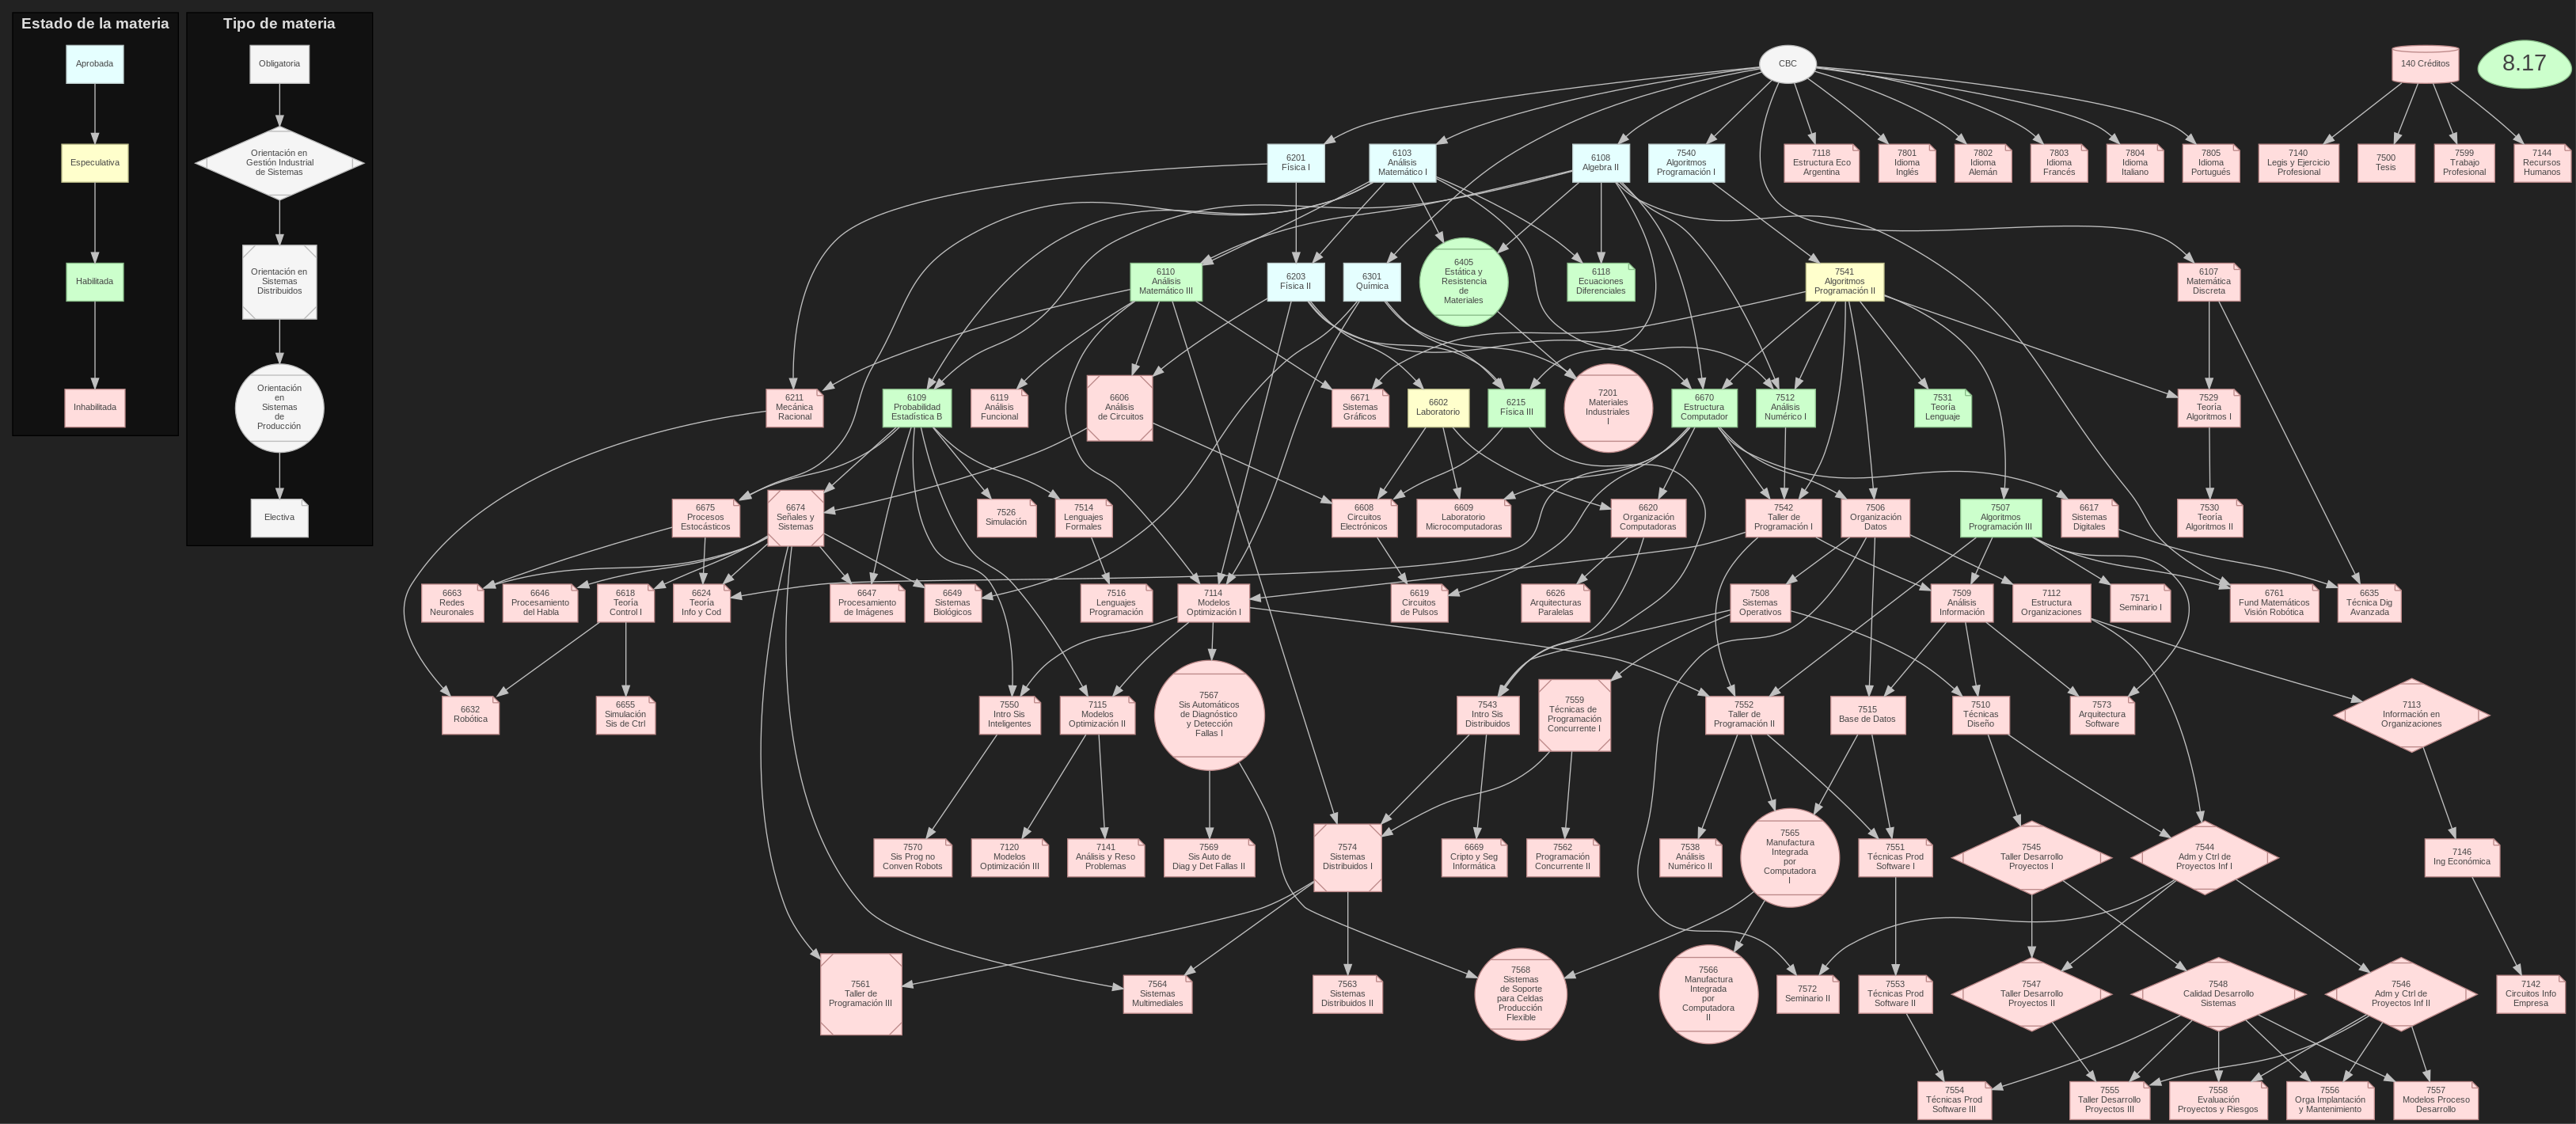

In [18]:
result = G.draw(format='png', prog='dot')
Image(data=result)